In [77]:
import pandas as pd
import datetime as dt
import numpy as np 
from numpy import where as IF
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### 1. Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions

In [19]:
claims = pd.read_csv('E:/Python/Case Study 3 - Insurance Claims Case Study/claims.csv')
demographics = pd.read_csv('E:/Python/Case Study 3 - Insurance Claims Case Study/cust_demographics.csv')

In [20]:
claims.rename(columns={'customer_id':'CUST_ID'},inplace= True)

In [33]:
combo_df = pd.merge(left = claims, right = demographics,how = 'outer', on ='CUST_ID')
combo_df

,claim_id,CUST_ID,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment
0,54004764.0,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No,Female,12-Jan-79,VT,789-916-8172,Platinum
1,33985796.0,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No,Female,13-Jan-70,ME,265-543-1264,Silver
2,53522022.0,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1.0,Yes,Female,11-Mar-84,TN,798-631-4758,Silver
3,63017412.0,30308357,Driver error,04/04/2018,Auto,No,Material only,$1950,6.0,No,Female,11-Mar-84,TN,798-631-4758,Silver
4,13015401.0,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1.0,No,Female,01-May-86,MA,413-187-7945,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,NaN,74888099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,22-Jul-80,CO,125-613-7698,Platinum
1103,NaN,36009093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,04-Jun-84,SC,264-374-5794,Platinum
1104,NaN,60016590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,25-May-84,NV,649-742-8132,Silver
1105,NaN,96861647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,06-Aug-96,NH,495-732-2638,Silver


###  2. Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their business significance

In [5]:
combo_df.dtypes

claim_id               float64
CUST_ID                  int64
incident_cause          object
claim_date              object
claim_area              object
police_report           object
claim_type              object
claim_amount            object
total_policy_claims    float64
fraudulent              object
gender                  object
DateOfBirth             object
State                   object
Contact                 object
Segment                 object
dtype: object

In [34]:


combo_df['DateOfBirth'] = pd.to_datetime(combo_df['DateOfBirth'],format = "%d-%b-%y")
mask = combo_df['DateOfBirth'].dt.year > 2000
combo_df.loc[mask,'DateOfBirth']-= np.timedelta64(100,'Y')
combo_df['claim_date']= pd.to_datetime(combo_df['claim_date'],format = "%m/%d/%Y" )
combo_df["claim_amount"] = pd.to_numeric(combo_df["claim_amount"].astype(str).str.replace("$", ""), errors='coerce', downcast='float')
combo_df["Contact"] = pd.to_numeric(combo_df['Contact'].astype(str).str.replace("-",""),errors='coerce',downcast='float')



C:\Users\ASUS\AppData\Local\Temp\ipykernel_5712\3842070354.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combo_df["claim_amount"] = pd.to_numeric(combo_df["claim_amount"].astype(str).str.replace("$", ""), errors='coerce', downcast='float')



#### 4. Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims.


In [35]:
combo_df['flag'] = IF(combo_df.police_report=='No',0,
                      IF(combo_df.police_report=='Yes',1,np.nan))
combo_df.drop(columns = ["police_report"], inplace = True)

combo_df.head()


,claim_id,CUST_ID,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,flag
0,54004764.0,21868593,Driver error,2017-11-27,Auto,Material only,2980.0,1.0,No,Female,1979-01-12,VT,7.899168e+09,Platinum,0.0
1,33985796.0,75740424,Crime,2018-10-03,Home,Material only,2980.0,3.0,No,Female,1970-01-13,ME,2.655431e+09,Silver,NaN
2,53522022.0,30308357,Other driver error,2018-02-02,Auto,Material only,3369.5,1.0,Yes,Female,1984-03-11,TN,7.986315e+09,Silver,0.0
3,63017412.0,30308357,Driver error,2018-04-04,Auto,Material only,1950.0,6.0,No,Female,1984-03-11,TN,7.986315e+09,Silver,0.0
4,13015401.0,47830476,Natural causes,2018-06-17,Auto,Material only,1680.0,1.0,No,Female,1986-05-01,MA,4.131878e+09,Silver,0.0


#### 5. One customer can claim for insurance more than once and in each claim,multiple categories of claims can be involved. However, customer ID should remain unique. Retain the most recent observation and delete any duplicated records inthe data based on the customer ID column.


In [36]:
combo_df = combo_df.groupby('CUST_ID').first().reset_index(drop = True)
combo_df.head()

,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,flag
0,69348631.0,Driver error,2018-04-10,Auto,Injury only,NaN,1.0,Yes,Female,1978-05-23,DE,9.628791e+09,Platinum,0.0
1,40953049.0,Other causes,2018-04-04,Auto,Material and injury,39192.0,1.0,Yes,Male,1972-12-20,TX,1.738926e+09,Silver,0.0
2,45780237.0,Natural causes,2017-10-17,Auto,Material only,1621.5,2.0,Yes,Male,1988-07-28,FL,3.645982e+09,Silver,NaN
3,89833962.0,Other causes,2018-03-21,Auto,Material and injury,37040.0,1.0,No,Male,1971-08-19,CA,1.873488e+09,Gold,1.0
4,35782742.0,Other driver error,2018-07-27,Auto,Injury only,35250.0,3.0,No,Female,1980-08-10,NC,7.988625e+09,Gold,0.0


#### 6. Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)


In [37]:
cat_col = combo_df.select_dtypes(include=['object']).columns
con_col = combo_df.select_dtypes(include=['number']).columns

combo_df[con_col] = combo_df[con_col].apply(lambda col : col.fillna(col.mean()))
combo_df[cat_col] = combo_df[cat_col].apply(lambda col : col.fillna(col.mode()[0]))




In [38]:
combo_df.head()

,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,flag
0,69348631.0,Driver error,2018-04-10,Auto,Injury only,12444.727539,1.0,Yes,Female,1978-05-23,DE,9.628791e+09,Platinum,0.0000
1,40953049.0,Other causes,2018-04-04,Auto,Material and injury,39192.000000,1.0,Yes,Male,1972-12-20,TX,1.738926e+09,Silver,0.0000
2,45780237.0,Natural causes,2017-10-17,Auto,Material only,1621.500000,2.0,Yes,Male,1988-07-28,FL,3.645982e+09,Silver,0.2133
3,89833962.0,Other causes,2018-03-21,Auto,Material and injury,37040.000000,1.0,No,Male,1971-08-19,CA,1.873488e+09,Gold,1.0000
4,35782742.0,Other driver error,2018-07-27,Auto,Injury only,35250.000000,3.0,No,Female,1980-08-10,NC,7.988625e+09,Gold,0.0000


#### 7. Calculate the age of customers in years. Based on the age, categorize thecustomers according to the below criteria
#### Children < 18
#### Youth 18-30
#### Adult 30-60
#### Senior > 60

In [40]:
combo_df["Age"] = round((combo_df.claim_date - combo_df.DateOfBirth).apply(lambda x: x.days)/365.25, 0)


In [41]:
combo_df["Age_grp"] = IF(combo_df.Age < 18, "Children",
                        IF(combo_df.Age < 30, "Youth",
                         IF(combo_df.Age < 60, "Adult",
                          IF(combo_df.Age < 100, "Senior", "NaN"
                           
                          )
                         )
                        )
                       )
combo_df["Age_grp"] = combo_df["Age_grp"].fillna(combo_df["Age_grp"].mode())
combo_df.groupby(by = "Age_grp").count()

,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,flag,Age
Age_grp,,,,,,,,,,,,,,,
Adult,758,758,758,758,758,758,758,758,758,758,758,758,758,758,758
Children,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
NaN,22,22,15,22,22,22,22,22,22,7,22,22,22,22,0
Youth,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318


####  8. What is the average amount claimed by the customers from various segments?

In [11]:
avg_amt_claim = combo_df.groupby(by='Segment').agg({'claim_amount': 'mean'}).sort_values(by='claim_amount', ascending=False).round(2)
avg_amt_claim


,claim_amount
Segment,
Gold,12674.669922
Platinum,12368.860352
Silver,12268.870117


#### 9. What is the total claim amount based on incident cause for all the claimsthat have been done at least 20 days prior to 1st of October, 2018

In [12]:
total_claim = combo_df.loc[combo_df['claim_date']<'10/01/2018',:].groupby(by='incident_cause')['claim_amount'].sum()
total_claim

incident_cause
Crime                  736325.625
Driver error          3307561.500
Natural causes        1323442.000
Other causes          4024879.500
Other driver error    3431678.500
Name: claim_amount, dtype: float32

#### 10. How many adults from TX, DE and AK claimed insurance for driver related issues and causes? 

In [13]:
Result  =combo_df.loc[(combo_df.incident_cause.str.lower().str.contains("driver") 
& ((combo_df.State == "TX") | (combo_df.State == "DE") | (combo_df.State == "AK")))& (combo_df.age >=45), :].groupby(by = "State")["State"].count()

Result

State
AK    4
DE    7
TX    6
Name: State, dtype: int64

####  11. Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.


In [14]:
gender_segment = combo_df.groupby(by=['gender','Segment'])['claim_amount'].sum().reset_index().round(2)

gender_segment

,gender,Segment,claim_amount
0,Female,Gold,2121976.250
1,Female,Platinum,2381767.750
2,Female,Silver,1935557.625
3,Male,Gold,2783120.000
4,Male,Platinum,2120498.750
5,Male,Silver,2346279.500


In [45]:
gender_segment = gender_segment.pivot(index = "Segment", columns = "gender", values = "claim_amount")
gender_segment

gender,Female,Male
Segment,,
Gold,2121976.250,2783120.00
Platinum,2381767.750,2120498.75
Silver,1935557.625,2346279.50


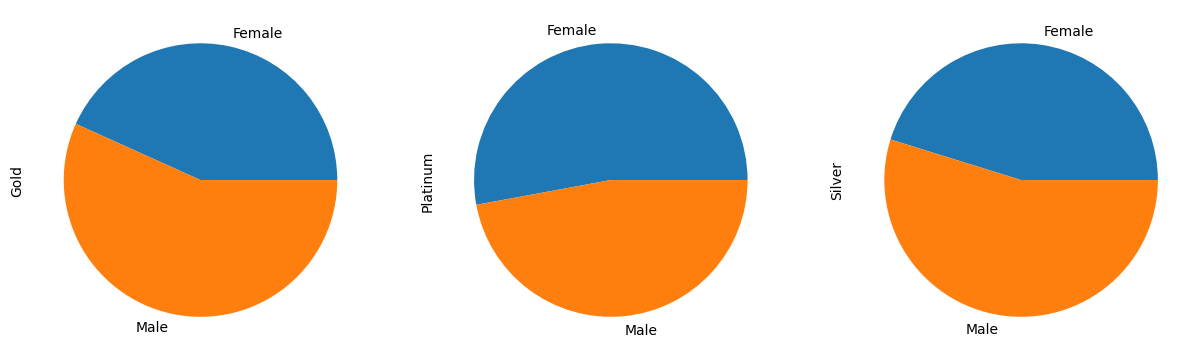

In [47]:
gender_segment.T.plot(kind = "pie", subplots = True, legend = False, figsize = (15,8))
plt.show()

#### 12. Among males and females, which gender had claimed the most for any type of driver related issues? E.g. This metric can be compared using a bar chart      

In [49]:
gender_claim = combo_df.loc[combo_df.incident_cause.str.lower().str.contains('driver'),:].groupby(by=('gender'))['total_policy_claims'].count()

gender_claim

gender
Female    221
Male      285
Name: total_policy_claims, dtype: int64

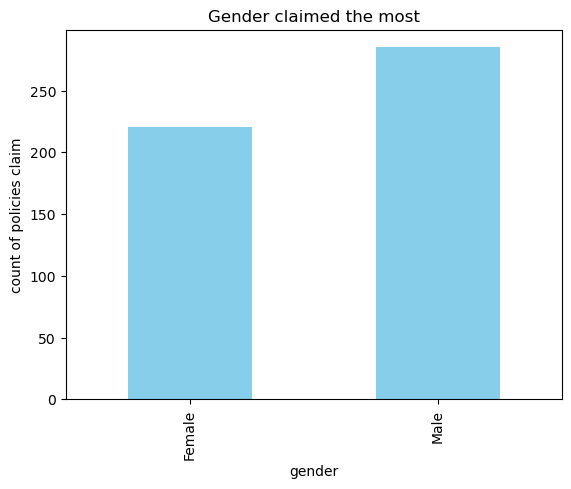

In [50]:
gender_claim.plot(kind='bar',color='skyblue')
plt.title('Gender claimed the most')
plt.ylabel('count of policies claim')
plt.show()


#### 13. Which age group had the maximum fraudulent policy claims? Visualize it on a bar chart.


In [52]:
combo_df

,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,flag,Age,Age_grp
0,69348631.0,Driver error,2018-04-10,Auto,Injury only,12444.727539,1.0,Yes,Female,1978-05-23 00:00:00,DE,9.628791e+09,Platinum,0.0000,40.0,Adult
1,40953049.0,Other causes,2018-04-04,Auto,Material and injury,39192.000000,1.0,Yes,Male,1972-12-20 00:00:00,TX,1.738926e+09,Silver,0.0000,45.0,Adult
2,45780237.0,Natural causes,2017-10-17,Auto,Material only,1621.500000,2.0,Yes,Male,1988-07-28 00:00:00,FL,3.645982e+09,Silver,0.2133,29.0,Youth
3,89833962.0,Other causes,2018-03-21,Auto,Material and injury,37040.000000,1.0,No,Male,1971-08-19 00:00:00,CA,1.873488e+09,Gold,1.0000,47.0,Adult
4,35782742.0,Other driver error,2018-07-27,Auto,Injury only,35250.000000,3.0,No,Female,1980-08-10 00:00:00,NC,7.988625e+09,Gold,0.0000,38.0,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,4549014.0,Other causes,2018-07-07,Auto,Injury only,21480.000000,1.0,No,Male,1965-01-28 18:00:00,UT,5.175625e+09,Silver,0.0000,53.0,Adult
1096,35453672.0,Natural causes,2018-01-06,Auto,Material and injury,14360.000000,1.0,No,Female,1966-06-19 18:00:00,HI,4.577521e+09,Gold,1.0000,52.0,Adult
1097,37305754.0,Natural causes,2018-04-04,Auto,Material only,1242.000000,1.0,Yes,Female,1963-11-18 18:00:00,NC,6.432465e+09,Silver,0.0000,54.0,Adult
1098,22960702.0,Driver error,2017-11-13,Auto,Material only,2415.000000,2.0,Yes,Male,1995-06-08 00:00:00,OR,3.952466e+09,Gold,0.0000,22.0,Youth


In [53]:
max_fraud = combo_df.groupby(by='Age_grp')[['fraudulent']].count()

max_fraud

,fraudulent
Age_grp,
Adult,758
Children,2
NaN,22
Youth,318


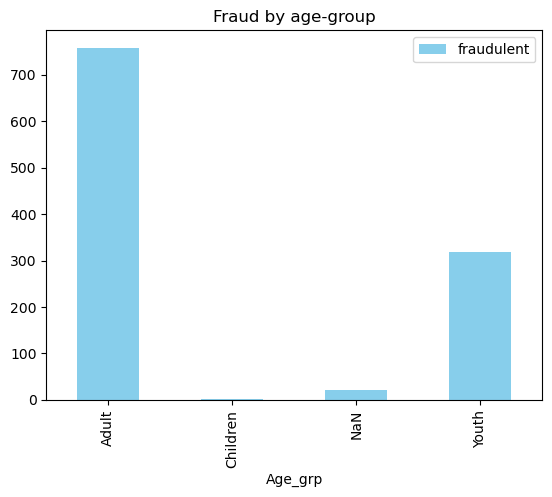

In [54]:
max_fraud.plot(kind='bar',color='skyblue')
plt.title('Fraud by age-group')
plt.show()

#### 14. Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order.  

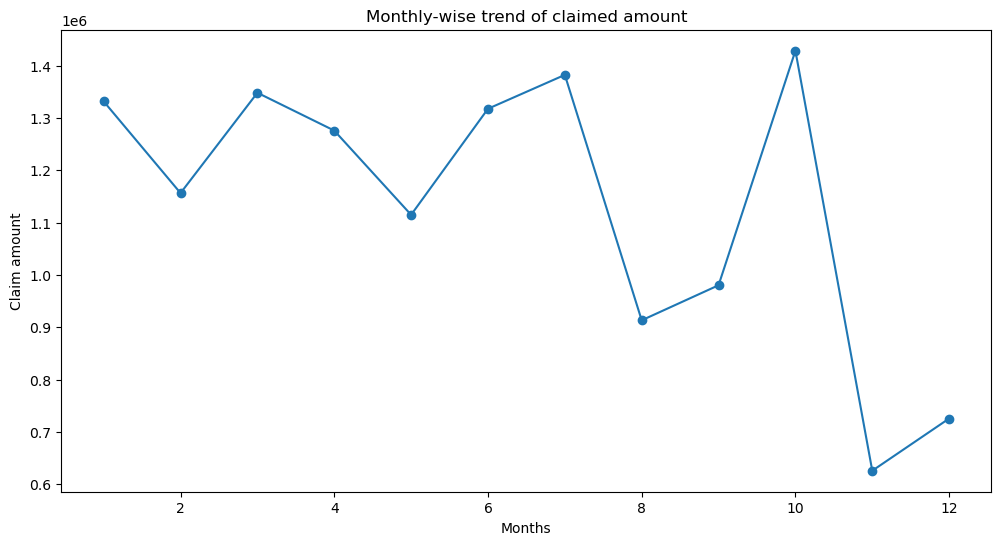

In [55]:
result = combo_df.groupby(by=combo_df['claim_date'].dt.month)['claim_amount'].sum()

plt.figure(figsize=(12,6))
result.plot(kind='line',marker='o',linestyle='-')
plt.title('Monthly-wise trend of claimed amount')
plt.xlabel('Months')
plt.ylabel('Claim amount')
plt.show()

#### 15. What is the average claim amount for gender and age categories and suitably represent the above using a facetted bar chart, one facet that represents fraudulent claims and the other for non-fraudulent claims

In [62]:
Avg_Claim_Amt= combo_df.groupby(by=['gender','Age_grp','fraudulent'])[['claim_amount']].mean().reset_index()
Avg_Claim_Amt

,gender,Age_grp,fraudulent,claim_amount
0,Female,Adult,No,12408.307617
1,Female,Adult,Yes,12346.311523
2,Female,Children,No,20200.000000
3,Female,NaN,No,12444.727539
4,Female,Youth,No,12397.113281
5,Female,Youth,Yes,7753.825684
6,Male,Adult,No,12148.764648
7,Male,Adult,Yes,17060.957031
8,Male,Children,No,24610.000000
9,Male,NaN,No,11181.945312


In [63]:
Avg_Claim_Amt_Male = Avg_Claim_Amt.loc[ Avg_Claim_Amt.gender == 'Male', ['claim_amount','Age_grp','fraudulent'] ]
Avg_Claim_Amt_Female = Avg_Claim_Amt.loc[ Avg_Claim_Amt.gender == 'Female', ['claim_amount','Age_grp','fraudulent'] ]


In [64]:
Avg_Claim_Amt_Male_fraudulent = Avg_Claim_Amt_Male.loc[ Avg_Claim_Amt.fraudulent == 'Yes', ['claim_amount','Age_grp'] ]
Avg_Claim_Amt_Male_nonfraudulent = Avg_Claim_Amt_Male.loc[ Avg_Claim_Amt.fraudulent == 'No', ['claim_amount','Age_grp'] ]
Avg_Claim_Amt_Female_fraudulent = Avg_Claim_Amt_Female.loc[ Avg_Claim_Amt.fraudulent == 'Yes', ['claim_amount','Age_grp'] ]
Avg_Claim_Amt_Female_nonfraudulent = Avg_Claim_Amt_Female.loc[ Avg_Claim_Amt.fraudulent == 'No', ['claim_amount','Age_grp'] ]

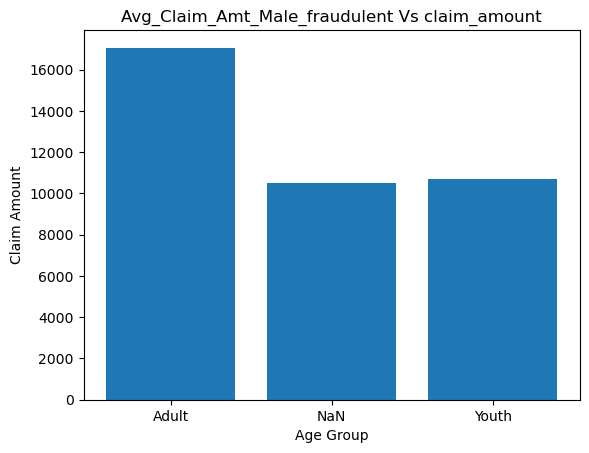

In [65]:
plt.bar(Avg_Claim_Amt_Male_fraudulent.Age_grp , Avg_Claim_Amt_Male_fraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Male_fraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

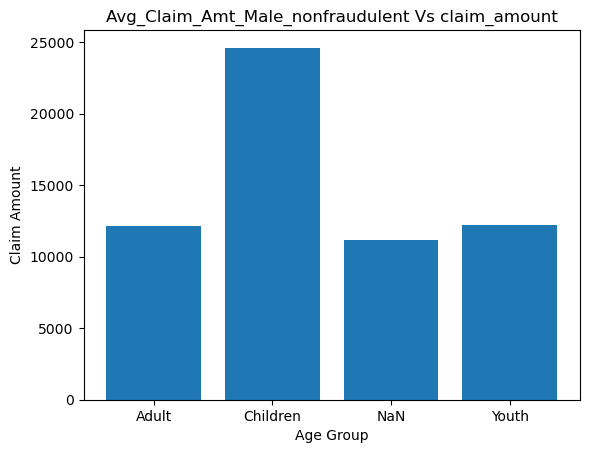

In [66]:
plt.bar(Avg_Claim_Amt_Male_nonfraudulent.Age_grp , Avg_Claim_Amt_Male_nonfraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Male_nonfraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

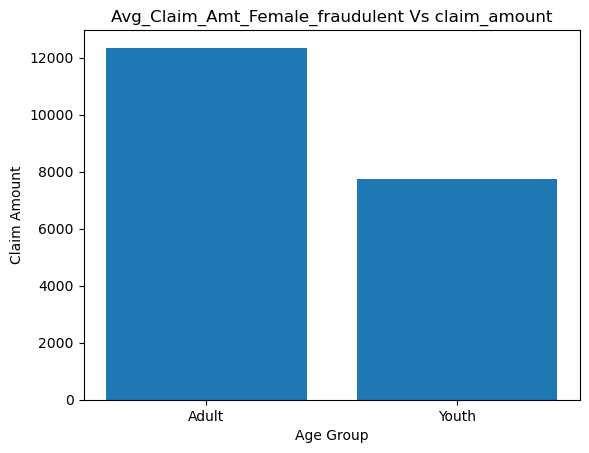

In [67]:
plt.bar(Avg_Claim_Amt_Female_fraudulent.Age_grp , Avg_Claim_Amt_Female_fraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Female_fraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

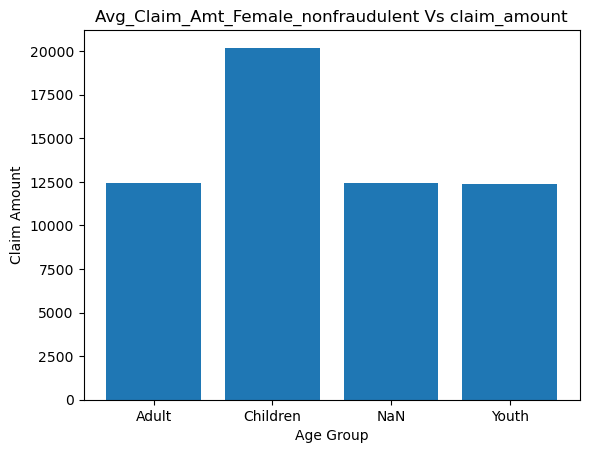

In [68]:
plt.bar(Avg_Claim_Amt_Female_nonfraudulent.Age_grp , Avg_Claim_Amt_Female_nonfraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Female_nonfraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

#### 16. Is there any similarity in the amount claimed by males and females?

In [70]:
combo_df.gender.value_counts()

Male      568
Female    532
Name: gender, dtype: int64

In [71]:
combo_df_Gender =  combo_df.groupby(["gender", "claim_date"])[["claim_amount"]].sum().reset_index()


In [72]:
combo_df_Gender['Monthly'] = combo_df_Gender['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%B"))
combo_df_Gender['Yearly'] = combo_df_Gender['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%Y"))


In [73]:
combo_df_Gender.head()

,gender,claim_date,claim_amount,Monthly,Yearly
0,Female,2017-01-01,119620.000000,January,2017
1,Female,2017-01-07,4576.500000,January,2017
2,Female,2017-01-14,85203.000000,January,2017
3,Female,2017-01-21,23353.726562,January,2017
4,Female,2017-01-27,6507.500000,January,2017


In [75]:
Claim_amt = 'claim_amount'

male_spend = combo_df_Gender.loc[ combo_df_Gender.gender == "Male", Claim_amt ]
female_spend = combo_df_Gender.loc[ combo_df_Gender.gender == "Female", Claim_amt ]

print( 'mean of male spend: ', male_spend.mean(), '| mean of female spend: ', female_spend.mean() )

mean of male spend:  72979.88 | mean of female spend:  63770.773


In [78]:
stats.ttest_ind( male_spend, female_spend )

Ttest_indResult(statistic=1.58427569629333, pvalue=0.11473496202272535)

In [79]:
stats.f_oneway( male_spend, female_spend )

F_onewayResult(statistic=2.5099272501240835, pvalue=0.11473512228887894)

In [80]:
print (" Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship for the amount claimed by males and females" )


 Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship for the amount claimed by males and females


#### 17. Is there any relationship between age category and segment?

In [82]:
obs_freq = pd.crosstab( combo_df.Segment, combo_df.Age_grp )
obs_freq

Age_grp,Adult,Children,NaN,Youth
Segment,,,,
Gold,268,1,16,102
Platinum,244,1,3,116
Silver,246,0,3,100


In [83]:
stats.chi2_contingency( obs_freq )


Chi2ContingencyResult(statistic=16.833931934292377, pvalue=0.009913341983363926, dof=6, expected_freq=array([[266.67818182,   0.70363636,   7.74      , 111.87818182],
       [250.82909091,   0.66181818,   7.28      , 105.22909091],
       [240.49272727,   0.63454545,   6.98      , 100.89272727]]))

In [84]:
print (" Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship between age category and segment" )


 Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship between age category and segment


#### 18. The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.